<a href="https://colab.research.google.com/github/GladyshevVitaly/ML-housing-prices/blob/main/Housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ цен на недвижимость

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [3]:
def print_score(y_true, y_pred):
    p_r2 = r2_score(y_true, y_pred)
    p_mae = mean_absolute_error(y_true, y_pred)
    print("r2: {:.4f}  MAE: {:,.0f}".format(p_r2, p_mae))

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

In [5]:
data = pd.read_csv("train.csv", sep=",")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
data.describe()

Id    DistrictId  ...       Shops_1          Price
count  10000.00000  10000.000000  ...  10000.000000   10000.000000
mean    8383.40770     50.400800  ...      4.231300  214138.857399
std     4859.01902     43.587592  ...      4.806341   92872.293865
min        0.00000      0.000000  ...      0.000000   59174.778028
25%     4169.50000     20.000000  ...      1.000000  153872.633942
50%     8394.50000     36.000000  ...      3.000000  192269.644879
75%    12592.50000     75.000000  ...      6.000000  249135.462171
max    16798.00000    209.000000  ...     23.000000  633233.466570

[8 rows x 17 columns]

In [8]:
data.corr()

Id  DistrictId     Rooms  ...  Helthcare_2   Shops_1     Price
Id             1.000000    0.012973 -0.005847  ...     0.001502 -0.008718  0.009880
DistrictId     0.012973    1.000000  0.071432  ...     0.306147  0.174214  0.265100
Rooms         -0.005847    0.071432  1.000000  ...     0.063557  0.053618  0.550291
Square        -0.010071   -0.026613  0.662893  ...    -0.022960  0.021357  0.520075
LifeSquare     0.018449   -0.019910  0.131336  ...    -0.024762 -0.007569  0.081292
KitchenSquare  0.019880    0.040358  0.005123  ...     0.043170  0.010216  0.028864
Floor          0.001348   -0.120373 -0.000665  ...    -0.065537  0.024264  0.128715
HouseFloor    -0.008376   -0.149051 -0.029302  ...    -0.068728  0.026279  0.088280
HouseYear      0.005004    0.013430 -0.010612  ...     0.011245  0.003681  0.004305
Ecology_1      0.018097    0.065294 -0.032347  ...     0.030873 -0.076749 -0.058381
Social_1      -0.000772    0.246463  0.075980  ...     0.524593  0.526272  0.263286
Social_2      -0.002033    0.167479  0.071335  ...     0.473193  0.559163  0.239226
Social_3      -0.009358    0.136095  0.012811  ...     0.286434  0.662113  0.074878
Healthcare_1  -0.003879    0.304335  0.042857  ...     0.203177  0.057758  0.138755
Helthcare_2    0.001502    0.306147  0.063557  ...     1.000000  0.474085  0.253090
Shops_1       -0.008718    0.174214  0.053618  ...     0.474085  1.000000  0.180876
Price          0.009880    0.265100  0.550291  ...     0.253090  0.180876  1.000000

[17 rows x 17 columns]

In [9]:
data = data.drop('Healthcare_1', axis=1)

In [10]:
data.loc[(~data['HouseYear'].between(1915, 2020)), 'HouseYear'].sort_values()

9317        1910
2656        1912
5111        1912
910         1914
4189        4968
1497    20052011
Name: HouseYear, dtype: int64

In [11]:
data.loc[4189, 'HouseYear'] = 1968
data.loc[1497, 'HouseYear'] = 2011

In [12]:
data.loc[data['Rooms']>5]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
377    5927          57   10.0  ...       15        B  317265.323792
1454   8491           1   19.0  ...        1        B   78364.616704
2170  14003          99    6.0  ...        8        B  229661.964416
8849  14865           9   10.0  ...        4        B  172329.270863

[4 rows x 19 columns]

In [13]:
data.loc[377, 'Rooms'] = 3
data.loc[1454, 'Rooms'] = 2
data.loc[2170, 'Rooms'] = 3
data.loc[8849, 'Rooms'] = 3

In [14]:
data.loc[data['Rooms']==0]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
1397  12638          27    0.0  ...        0        B  268394.744389
1981   7917          27    0.0  ...        1        B  302211.260887
2269   7317          27    0.0  ...        1        B   98129.976788
3911    770          28    0.0  ...        0        B  217009.338463
4366    456           6    0.0  ...        0        B  212864.799112
4853   3224          27    0.0  ...        0        B  126596.941798
6149   3159          88    0.0  ...        9        B  158998.110646
8834   9443          27    0.0  ...        1        B  219281.918007

[8 rows x 19 columns]

In [15]:
data.drop(data.loc[data['Rooms']==0].index, axis=0, inplace=True)

In [16]:
data.loc[data['Rooms']==5, 'Square']

1422     95.617533
1503    108.057398
1982    275.645284
3268    121.577423
3271     42.003293
4431     39.906082
4487    183.382273
4762    114.313752
5361    118.871952
5466    112.135525
6623    111.045799
6988    124.933289
8511    198.930182
8659    119.008007
8726     90.762276
8925     85.313605
9432    147.709302
9699    117.855969
Name: Square, dtype: float64

In [17]:
data.drop([3271, 4431], axis=0, inplace=True)

In [18]:
data.loc[6977]

Id                     11602
DistrictId                30
Rooms                      2
Square               641.065
LifeSquare           638.163
KitchenSquare             10
Floor                     20
HouseFloor                19
HouseYear               2019
Ecology_1        7.81528e-05
Ecology_2                  B
Ecology_3                  B
Social_1                  22
Social_2                6398
Social_3                 141
Helthcare_2                3
Shops_1                   23
Shops_2                    B
Price                 133530
Name: 6977, dtype: object

In [19]:
data.loc[6977, 'Square'] = 64.1065
data.loc[6977, 'LifeSquare'] = 63.8163
data.loc[4262, 'Square'] = 60.4706
data.loc[4262, 'LifeSquare'] = 60.3706
data.loc[4690, 'Square'] = 40.9425
data.loc[4690, 'LifeSquare'] = 41.064
data.loc[4328, 'LifeSquare'] = 74.8059
data.loc[1064, 'KitchenSquare'] = data.loc[1064, 'Square'] - data.loc[1064, 'LifeSquare']
data.loc[8584, 'KitchenSquare'] = data.loc[8584, 'Square'] - data.loc[8584, 'LifeSquare']

In [20]:
data.loc[data['Square']<15]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
212    1748          88    2.0  ...        9        B  412511.088764
1316  11526          27    1.0  ...        0        B  107604.269441
1608  10202           6    1.0  ...        0        B  137597.601458
3280  10527          27    1.0  ...        1        B   97560.720383
3413   9487           5    1.0  ...        5        B  369472.403061
4739  12676          81    3.0  ...        8        B   78388.806186
4900   4504          27    3.0  ...        1        B  161379.067034
6392  14786           1    1.0  ...        1        B  181434.825589
8030  13265           1    3.0  ...        1        B  237716.681261
8283  15744          34    1.0  ...       11        B  458378.777006
9294   6782          45    1.0  ...        2        B  438005.182323
9613   7657          38    1.0  ...        7        B  483283.488083

[12 rows x 19 columns]

In [21]:
data = data.drop(data.loc[data['Square']<15].index, axis=0)

In [22]:
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [23]:
data.loc[data['LifeSquare']>250]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
590   14990          23    2.0  ...        2        B  141780.231857
8437  15886          85    3.0  ...        7        B  394253.299978

[2 rows x 19 columns]

In [24]:
data = data.drop(data.loc[data['LifeSquare']>250].index, axis=0)

## Анализ данных

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9976 non-null   int64  
 1   DistrictId     9976 non-null   int64  
 2   Rooms          9976 non-null   float64
 3   Square         9976 non-null   float64
 4   LifeSquare     9976 non-null   float64
 5   KitchenSquare  9976 non-null   float64
 6   Floor          9976 non-null   int64  
 7   HouseFloor     9976 non-null   float64
 8   HouseYear      9976 non-null   int64  
 9   Ecology_1      9976 non-null   float64
 10  Ecology_2      9976 non-null   object 
 11  Ecology_3      9976 non-null   object 
 12  Social_1       9976 non-null   int64  
 13  Social_2       9976 non-null   int64  
 14  Social_3       9976 non-null   int64  
 15  Helthcare_2    9976 non-null   int64  
 16  Shops_1        9976 non-null   int64  
 17  Shops_2        9976 non-null   object 
 18  Price   

In [26]:
data.describe()

Id   DistrictId  ...      Shops_1          Price
count   9976.000000  9976.000000  ...  9976.000000    9976.000000
mean    8382.660485    50.439354  ...     4.234463  214090.505009
std     4859.514979    43.614145  ...     4.808666   92777.647406
min        0.000000     0.000000  ...     0.000000   59174.778028
25%     4167.750000    20.000000  ...     1.000000  153907.528147
50%     8394.500000    36.000000  ...     3.000000  192255.017896
75%    12591.250000    75.000000  ...     6.000000  249100.769116
max    16798.000000   209.000000  ...    23.000000  633233.466570

[8 rows x 16 columns]

In [28]:
# data.corr()

In [29]:
data.Ecology_2.unique()

array(['B', 'A'], dtype=object)

In [30]:
data.Ecology_3.unique()

array(['B', 'A'], dtype=object)

In [31]:
data.Shops_2.unique()

array(['B', 'A'], dtype=object)

In [32]:
data.DistrictId.nunique()

205

In [33]:
data.groupby(['Ecology_2', 'Ecology_3', 'Shops_2'])['Price'].mean().sort_values()

Ecology_2  Ecology_3  Shops_2
A          B          A          159386.651546
B          B          A          192908.557092
A          B          B          198833.005156
B          B          B          215365.530129
           A          B          243179.560704
Name: Price, dtype: float64

In [34]:
data.groupby(['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'])['Price'].mean().sort_values()

DistrictId  Ecology_2  Ecology_3  Shops_2
23          B          B          B          126787.814437
158         B          B          B          129080.871245
23          B          B          A          134143.042318
209         B          B          B          140048.802277
27          B          B          B          146185.696061
                                                 ...      
199         B          B          B          432546.129741
182         B          B          B          441284.916612
181         B          B          B          450654.779595
190         B          B          B          471966.746348
195         B          B          B          482791.138606
Name: Price, Length: 239, dtype: float64

In [35]:
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9976 non-null   int64  
 1   DistrictId     9976 non-null   int64  
 2   Rooms          9976 non-null   float64
 3   Square         9976 non-null   float64
 4   LifeSquare     9976 non-null   float64
 5   KitchenSquare  9976 non-null   float64
 6   Floor          9976 non-null   int64  
 7   HouseFloor     9976 non-null   float64
 8   HouseYear      9976 non-null   int64  
 9   Ecology_1      9976 non-null   float64
 10  Ecology_2      9976 non-null   int64  
 11  Ecology_3      9976 non-null   int64  
 12  Social_1       9976 non-null   int64  
 13  Social_2       9976 non-null   int64  
 14  Social_3       9976 non-null   int64  
 15  Helthcare_2    9976 non-null   int64  
 16  Shops_1        9976 non-null   int64  
 17  Shops_2        9976 non-null   int64  
 18  Price   

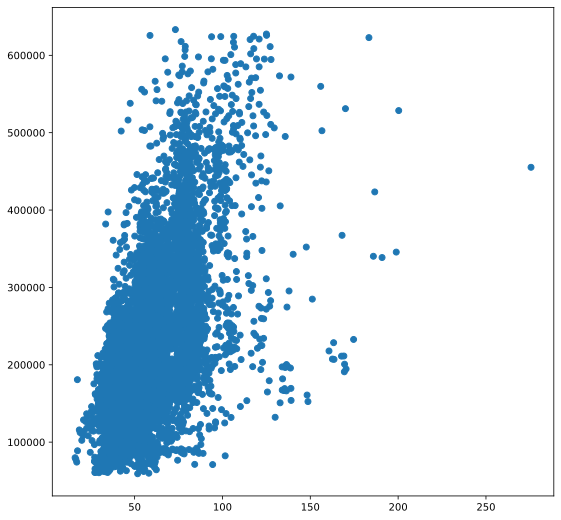

In [37]:
rcParams["figure.figsize"] = 9, 9
plt.scatter(data['Square'], data['Price'])
plt.show()

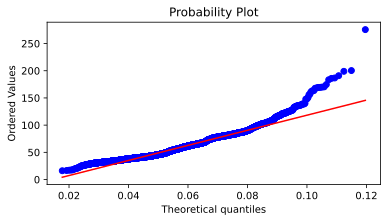

In [38]:
fig, ax = plt.subplots(figsize=(6, 3))

_ = stats.probplot(
    data['Square'],       # data
    sparams=(16.117154, 275.645284),  # guesses at the distribution parameters
    dist=stats.beta,   # the "dist" object
    plot=ax            # where the data should be plotted
)

In [39]:
data.loc[data['Square']>200]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
1982   5548          86    5.0  ...        7        1  455264.882666
9910  16568          27    4.0  ...        4        1  528560.506016

[2 rows x 19 columns]

In [40]:
data = data.drop(data.loc[data['Square']>200].index, axis=0)

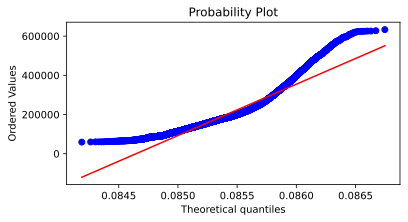

In [41]:
fig, ax = plt.subplots(figsize=(6, 3))

_ = stats.probplot(
    data['Price'],       # data
    sparams=(59174.778028, 633233.466570),  # guesses at the distribution parameters
    dist=stats.beta,   # the "dist" object
    plot=ax            # where the data should be plotted
)

In [42]:
data.to_csv("train_cor.csv", sep=",", index=False)

## Обработка тестовых данных

In [43]:
data_test = pd.read_csv("test.csv", sep=",")

In [44]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [45]:
data_test.describe()

Id   DistrictId  ...  Helthcare_2      Shops_1
count   5000.000000  5000.000000  ...   5000.00000  5000.000000
mean    8412.595400    51.279200  ...      1.31940     4.242800
std     4832.674037    44.179466  ...      1.47994     4.777365
min        1.000000     0.000000  ...      0.00000     0.000000
25%     4221.750000    21.000000  ...      0.00000     1.000000
50%     8320.500000    37.000000  ...      1.00000     3.000000
75%    12598.250000    77.000000  ...      2.00000     6.000000
max    16795.000000   212.000000  ...      6.00000    23.000000

[8 rows x 16 columns]

In [46]:
data_test = data_test.drop('Healthcare_1', axis=1)

In [47]:
data_test.loc[(~data_test['HouseYear'].between(1915, 2020)), 'HouseYear'].sort_values()

3253    1908
2       1909
2691    1910
64      1911
1475    1912
2856    1914
Name: HouseYear, dtype: int64

In [48]:
data_test.loc[data_test['Rooms']>5]

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
2071  10793          23    6.0  ...            0        0        B
3217   4058          27    6.0  ...            1        4        B
3398   1435         111   17.0  ...            2        4        B

[3 rows x 18 columns]

In [49]:
#data_test.drop(data_test.loc[data_test['Rooms']>5].index, axis=0, inplace=True)
data_test.loc[2071, 'Rooms'] = 3
data_test.loc[2071]

Id                  10793
DistrictId             23
Rooms                   3
Square             110.75
LifeSquare            NaN
KitchenSquare           0
Floor                   2
HouseFloor              2
HouseYear            2015
Ecology_1        0.014073
Ecology_2               B
Ecology_3               B
Social_1                2
Social_2              475
Social_3                0
Helthcare_2             0
Shops_1                 0
Shops_2                 B
Name: 2071, dtype: object

In [50]:
data_test.loc[3398, 'Rooms'] = 2
data_test.loc[3398]

Id                    1435
DistrictId             111
Rooms                    2
Square             52.8661
LifeSquare         32.5283
KitchenSquare            8
Floor                   15
HouseFloor              17
HouseYear             1987
Ecology_1        0.0934426
Ecology_2                B
Ecology_3                B
Social_1                23
Social_2              4635
Social_3                 5
Helthcare_2              2
Shops_1                  4
Shops_2                  B
Name: 3398, dtype: object

In [51]:
data_test.loc[data_test['Rooms']==0]

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
2406   3343          58    0.0  ...            0        5        B
2524  10729          27    0.0  ...            0        0        B

[2 rows x 18 columns]

In [52]:
#data_test.drop(data_test.loc[data_test['Rooms']==0].index, axis=0, inplace=True)
data_test.loc[2406, 'Rooms'] = 3
data_test.loc[2406]

Id                   3343
DistrictId             58
Rooms                   3
Square            116.824
LifeSquare        113.692
KitchenSquare           0
Floor                   3
HouseFloor              3
HouseYear            1977
Ecology_1        0.437885
Ecology_2               B
Ecology_3               B
Social_1               23
Social_2             5735
Social_3                3
Helthcare_2             0
Shops_1                 5
Shops_2                 B
Name: 2406, dtype: object

In [53]:
data_test.loc[2524, 'Rooms'] = 2
data_test.loc[2524]

Id                   10729
DistrictId              27
Rooms                    2
Square             76.3452
LifeSquare         42.8208
KitchenSquare           12
Floor                   14
HouseFloor               0
HouseYear             1977
Ecology_1        0.0176471
Ecology_2                B
Ecology_3                B
Social_1                 2
Social_2               469
Social_3                 0
Helthcare_2              0
Shops_1                  0
Shops_2                  B
Name: 2524, dtype: object

In [54]:
data_test.loc[data_test['Square']<15]

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
2      5480         190    1.0  ...            5        5        B
66     9011          53    1.0  ...            1        3        B
608   16401          30    1.0  ...            3       23        B
837    2138          27    1.0  ...            0        0        B
1165  10120           6    1.0  ...            0        0        B
3697  15435          21    1.0  ...            3        5        B
4490   1165          27    1.0  ...            0        0        B
4540   7855           6    1.0  ...            0        0        B
4713    170           6    2.0  ...            0        0        B
4902   1420          45    1.0  ...            3        2        B

[10 rows x 18 columns]

In [55]:
#data_test.drop(data_test.loc[data_test['Square']<15].index, axis=0, inplace=True)

In [56]:
data_test.loc[data_test['Square']>200]

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
3217  4058          27    6.0  ...            1        4        B
3909  1397          76    3.0  ...            1        5        B

[2 rows x 18 columns]

In [57]:
#data_test.drop(data_test.loc[data_test['Square']>200].index, axis=0, inplace=True)
data_test.loc[3909, 'Square'] = 121.138768
data_test.loc[3909]

Id                  1397
DistrictId            76
Rooms                  3
Square           121.139
LifeSquare       118.055
KitchenSquare          4
Floor                 32
HouseFloor            48
HouseYear           2011
Ecology_1              0
Ecology_2              B
Ecology_3              B
Social_1               7
Social_2            1660
Social_3              39
Helthcare_2            1
Shops_1                5
Shops_2                B
Name: 3909, dtype: object

In [58]:
data_test['LifeSquare'] = data_test['LifeSquare'].fillna(data_test['LifeSquare'].mean())

In [59]:
data_test.loc[data_test['LifeSquare']>200]

Id  DistrictId  Rooms  ...  Helthcare_2  Shops_1  Shops_2
410  11533          94    2.0  ...            0        0        B

[1 rows x 18 columns]

In [60]:
#data_test.drop(data_test.loc[data_test['LifeSquare']>200].index, axis=0, inplace=True)

In [61]:
map_AB = {
    'A': 0,
    'B': 1
}
data_test["Ecology_2"] = data_test["Ecology_2"].map(map_AB)
data_test["Ecology_3"] = data_test["Ecology_3"].map(map_AB)
data_test["Shops_2"] = data_test["Shops_2"].map(map_AB)

#data_test=pd.get_dummies(data_test)

In [62]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   int64  
dtypes: float

In [63]:
data_test.describe()

Id   DistrictId  ...      Shops_1      Shops_2
count   5000.000000  5000.000000  ...  5000.000000  5000.000000
mean    8412.595400    51.279200  ...     4.242800     0.917600
std     4832.674037    44.179466  ...     4.777365     0.275001
min        1.000000     0.000000  ...     0.000000     0.000000
25%     4221.750000    21.000000  ...     1.000000     1.000000
50%     8320.500000    37.000000  ...     3.000000     1.000000
75%    12598.250000    77.000000  ...     6.000000     1.000000
max    16795.000000   212.000000  ...    23.000000     1.000000

[8 rows x 18 columns]

In [64]:
data_test.to_csv("test_cor.csv", sep=",", index=False)

## Применение линейной регрессии

In [65]:
data = pd.read_csv("train_cor.csv", sep=",")

In [66]:
X = data[['DistrictId', 'Square']]
y = data[['Price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_score(y_test, y_pred)

r2: 0.4202  MAE: 51,246


In [68]:
X = data.drop(['Id', 'Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis = 1)
y = data[['Price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_score(y_test, y_pred)

r2: 0.5221  MAE: 44,516


In [70]:
X = data.drop(['LifeSquare', 'Id', 'Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis = 1)
y = data[['Price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_score(y_test, y_pred)

r2: 0.5221  MAE: 44,513


In [72]:
X = data.drop(['Id', 'Price'], axis = 1)
y = data[['Price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_score(y_test, y_pred)

r2: 0.5289  MAE: 44,021


In [74]:
X = data.drop(['Id', 'Price', 'LifeSquare'], axis = 1)
y = data[['Price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print_score(y_test, y_pred)

r2: 0.5290  MAE: 44,017


## Применение RandomForestRegressor

In [76]:
data = pd.read_csv("train_cor.csv", sep=",")

#X = data.drop(['Price'], axis = 1)
X = data.drop(['LifeSquare', 'Id', 'Price'], axis = 1) #, 'Ecology_2', 'Ecology_3', 'Shops_2'
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(max_depth=16, n_estimators=1000, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)

r2: 0.7241  MAE: 28,218


### Проверяем на переобучение

In [77]:
y_pred_v = model.predict(X)

print_score(y, y_pred_v)

r2: 0.8818  MAE: 17,857


In [78]:
parameters = {
    'n_estimators': [50, 75, 100, 200, 300],
    'max_depth': np.arange(9, 17)
}

clf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5
)

In [79]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [80]:
cv_results = pd.DataFrame(clf.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [83]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score'] #, 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

param_max_depth param_n_estimators  mean_test_score
39              16                300         0.719008
34              15                300         0.718685
38              16                200         0.718634
36              16                 75         0.718145
29              14                300         0.718008
27              14                100         0.717586
33              15                200         0.717329
37              16                100         0.717292
23              13                200         0.716968
24              13                300         0.716578

### Разбиваем входные данные на две части. На первой учим с переобучением (но с валидацией), второй частью проверяем

In [86]:
data_h1 = pd.read_csv("train_cor_h1.csv", sep=",")

X_h1 = data_h1.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h1 = data_h1[['Price']]

X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(X_h1, y_h1, test_size=0.3, random_state=42)

model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train_h1, y_train_h1.values[:, 0])
y_pred_h1 = model.predict(X_test_h1)

print_score(y_test_h1, y_pred_h1)

r2: 0.7186  MAE: 29,835


In [87]:
y_pred_h1 = model.predict(X_train_h1)

print_score(y_train_h1, y_pred_h1)

r2: 0.9269  MAE: 16,610


In [88]:
data_h2 = pd.read_csv("train_cor_h2.csv", sep=",")

X_h2 = data_h2.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h2 = data_h2[['Price']]

y_pred_h2 = model.predict(X_h2)

print_score(y_h2, y_pred_h2)

r2: 0.6997  MAE: 30,419


#### варьируем random_state

In [89]:
data_h1 = pd.read_csv("train_cor_h1.csv", sep=",")
data_h2 = pd.read_csv("train_cor_h2.csv", sep=",")

X_h1 = data_h1.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h1 = data_h1[['Price']]
X_h2 = data_h2.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h2 = data_h2[['Price']]

for ind in range(0, 11):
    X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(X_h1, y_h1, test_size=0.3, random_state=ind)

    model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=ind)
    model.fit(X_train_h1, y_train_h1.values[:, 0])
    y_pred_h1 = model.predict(X_test_h1)
    y_pred_h2 = model.predict(X_h2)

    p_r2_h1 = r2_score(y_test_h1, y_pred_h1)
    p_mae_h1 = mean_absolute_error(y_test_h1, y_pred_h1)
    p_r2_h2 = r2_score(y_h2, y_pred_h2)
    p_mae_h2 = mean_absolute_error(y_h2, y_pred_h2)

    print("random_state: {} h1 r2: {:.4f}  MAE: {:,.0f}\th2 r2: {:.4f}  MAE: {:,.0f}".format(ind, p_r2_h1, p_mae_h1, p_r2_h2, p_mae_h2))


random_state: 0 h1 r2: 0.7423  MAE: 28,689	h2 r2: 0.6978  MAE: 30,286
random_state: 1 h1 r2: 0.7067  MAE: 30,267	h2 r2: 0.6934  MAE: 30,782
random_state: 2 h1 r2: 0.6888  MAE: 30,602	h2 r2: 0.6977  MAE: 30,489
random_state: 3 h1 r2: 0.7167  MAE: 29,531	h2 r2: 0.7101  MAE: 29,716
random_state: 4 h1 r2: 0.7133  MAE: 29,826	h2 r2: 0.6921  MAE: 30,827
random_state: 5 h1 r2: 0.7294  MAE: 30,004	h2 r2: 0.6921  MAE: 30,712
random_state: 6 h1 r2: 0.7313  MAE: 29,901	h2 r2: 0.6982  MAE: 30,615
random_state: 7 h1 r2: 0.7312  MAE: 28,845	h2 r2: 0.7038  MAE: 29,932
random_state: 8 h1 r2: 0.7331  MAE: 30,086	h2 r2: 0.6932  MAE: 30,434
random_state: 9 h1 r2: 0.7118  MAE: 30,524	h2 r2: 0.6964  MAE: 30,362
random_state: 10 h1 r2: 0.6949  MAE: 30,350	h2 r2: 0.6992  MAE: 30,216


#### Меняем h1 и h2 местами

In [90]:
data_h1 = pd.read_csv("train_cor_h2.csv", sep=",")
data_h2 = pd.read_csv("train_cor_h1.csv", sep=",")

X_h1 = data_h1.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h1 = data_h1[['Price']]
X_h2 = data_h2.drop(['LifeSquare', 'Id', 'Price'], axis = 1)
y_h2 = data_h2[['Price']]

for ind in range(0, 11):
    X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(X_h1, y_h1, test_size=0.3, random_state=ind)

    model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=ind)
    model.fit(X_train_h1, y_train_h1.values[:, 0])
    y_pred_h1 = model.predict(X_test_h1)
    y_pred_h2 = model.predict(X_h2)

    p_r2_h1 = r2_score(y_test_h1, y_pred_h1)
    p_mae_h1 = mean_absolute_error(y_test_h1, y_pred_h1)
    p_r2_h2 = r2_score(y_h2, y_pred_h2)
    p_mae_h2 = mean_absolute_error(y_h2, y_pred_h2)

    print("random_state: {} h2 r2: {:.4f}  MAE: {:,.0f}\th1 r2: {:.4f}  MAE: {:,.0f}".format(ind, p_r2_h1, p_mae_h1, p_r2_h2, p_mae_h2))

random_state: 0 h2 r2: 0.6668  MAE: 31,943	h1 r2: 0.7182  MAE: 29,615
random_state: 1 h2 r2: 0.7327  MAE: 28,488	h1 r2: 0.7217  MAE: 29,483
random_state: 2 h2 r2: 0.7186  MAE: 29,962	h1 r2: 0.7165  MAE: 30,066
random_state: 3 h2 r2: 0.7174  MAE: 30,043	h1 r2: 0.7194  MAE: 29,719
random_state: 4 h2 r2: 0.6951  MAE: 30,651	h1 r2: 0.7152  MAE: 29,840
random_state: 5 h2 r2: 0.6982  MAE: 29,800	h1 r2: 0.7210  MAE: 29,480
random_state: 6 h2 r2: 0.7111  MAE: 30,701	h1 r2: 0.7164  MAE: 29,780
random_state: 7 h2 r2: 0.6999  MAE: 29,518	h1 r2: 0.7131  MAE: 29,858
random_state: 8 h2 r2: 0.6742  MAE: 30,796	h1 r2: 0.7201  MAE: 29,525
random_state: 9 h2 r2: 0.6925  MAE: 30,963	h1 r2: 0.7160  MAE: 29,747
random_state: 10 h2 r2: 0.7061  MAE: 30,297	h1 r2: 0.7156  MAE: 29,978


#### h1 и h2 не полностью равноценны. Есть неоднородность, но не критичная... (если только в тестовых данных она не сильнее...)

### Анализ влияния набора фичей на коэффициент детерминации

In [91]:
data = pd.read_csv("train_cor.csv", sep=",")

#X = data.drop(['Price'], axis = 1)
X = data.drop(['LifeSquare', 'Id', 'Price'], axis = 1) #, 'Ecology_2', 'Ecology_3', 'Shops_2'
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)
full_set_err = r2_score(y_test, y_pred)

r2: 0.7235  MAE: 28,661


In [92]:
def feature_test(X, y, best_r2):
    max_r2 = 0
    max_r2_ind = 0
    new_best_r2 = best_r2
    for ind in range(0, X.shape[1]):
        X_drop = X.drop(X.keys()[ind], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3, random_state=42)
        model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
        model.fit(X_train, y_train.values[:, 0])
        y_pred = model.predict(X_test)
        temp_r2 = r2_score(y_test, y_pred)
        feature_score = temp_r2 - best_r2
        if feature_score > max_r2:
            new_best_r2 = temp_r2
            max_r2 = feature_score
            max_r2_ind = ind
        print("   {} {}:\t\t{:.4f}\tr2: {:.4f}".format((ind + 1), X.keys()[ind], feature_score, temp_r2))
    if max_r2:
        print("drop: {} r2: {:.5f}".format(X.keys()[max_r2_ind], max_r2))
        X.drop(X.keys()[max_r2_ind], axis=1, inplace=True)
        feature_test(X, y, new_best_r2)
    else:
        return new_best_r2


In [93]:
print(feature_test(X, y, full_set_err))

   1 DistrictId:		-0.0035	r2: 0.7200
   2 Rooms:		-0.0021	r2: 0.7214
   3 Square:		-0.0374	r2: 0.6861
   4 KitchenSquare:		-0.0094	r2: 0.7141
   5 Floor:		-0.0032	r2: 0.7203
   6 HouseFloor:		-0.0046	r2: 0.7189
   7 HouseYear:		-0.0041	r2: 0.7194
   8 Ecology_1:		-0.0090	r2: 0.7145
   9 Ecology_2:		-0.0010	r2: 0.7224
   10 Ecology_3:		0.0002	r2: 0.7237
   11 Social_1:		-0.0033	r2: 0.7201
   12 Social_2:		-0.0011	r2: 0.7223
   13 Social_3:		-0.0149	r2: 0.7086
   14 Helthcare_2:		-0.0021	r2: 0.7213
   15 Shops_1:		-0.0014	r2: 0.7221
   16 Shops_2:		-0.0007	r2: 0.7227
drop: Ecology_3 r2: 0.00021
   1 DistrictId:		-0.0015	r2: 0.7222
   2 Rooms:		-0.0026	r2: 0.7211
   3 Square:		-0.0374	r2: 0.6863
   4 KitchenSquare:		-0.0100	r2: 0.7137
   5 Floor:		-0.0034	r2: 0.7203
   6 HouseFloor:		-0.0055	r2: 0.7182
   7 HouseYear:		-0.0052	r2: 0.7185
   8 Ecology_1:		-0.0101	r2: 0.7136
   9 Ecology_2:		-0.0015	r2: 0.7222
   10 Social_1:		-0.0032	r2: 0.7205
   11 Social_2:		-0.0014	r2: 0.7223
   12 Soc

#### Получен оптимизированный набор фичей

In [94]:
#X = X.drop(['LifeSquare', 'Id', 'Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X.keys()

Index(['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [95]:
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)

r2: 0.7237  MAE: 28,672


### Поиск оптимального значения параметра n_estimators

In [96]:
for ind in range(1, 6):
    model = RandomForestRegressor(max_depth=12, n_estimators = ind * 25, random_state=42)
    model.fit(X_train, y_train.values[:, 0])
    y_pred = model.predict(X_test)
    print("n_estimators: {} r2: {:.4f} MAE: {:,.0f}".format(ind * 25, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)))

n_estimators: 25 r2: 0.7200 MAE: 28,883
n_estimators: 50 r2: 0.7223 MAE: 28,748
n_estimators: 75 r2: 0.7237 MAE: 28,672
n_estimators: 100 r2: 0.7231 MAE: 28,670
n_estimators: 125 r2: 0.7224 MAE: 28,674


### Поиск оптимального значения параметра max_depth

In [97]:
for ind in range(3, 18):
    model = RandomForestRegressor(max_depth = ind, n_estimators = 75, random_state=42)
    model.fit(X_train, y_train.values[:, 0])
    y_pred = model.predict(X_test)
    print("max_depth: {} r2: {:.4f} MAE: {:,.0f}".format(ind, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)))

max_depth: 3 r2: 0.5178 MAE: 44,579
max_depth: 4 r2: 0.5746 MAE: 40,650
max_depth: 5 r2: 0.6224 MAE: 37,713
max_depth: 6 r2: 0.6580 MAE: 35,092
max_depth: 7 r2: 0.6815 MAE: 33,047
max_depth: 8 r2: 0.6964 MAE: 31,510
max_depth: 9 r2: 0.7091 MAE: 30,389
max_depth: 10 r2: 0.7167 MAE: 29,593
max_depth: 11 r2: 0.7209 MAE: 29,024
max_depth: 12 r2: 0.7237 MAE: 28,672
max_depth: 13 r2: 0.7235 MAE: 28,534
max_depth: 14 r2: 0.7224 MAE: 28,397
max_depth: 15 r2: 0.7234 MAE: 28,263
max_depth: 16 r2: 0.7221 MAE: 28,344
max_depth: 17 r2: 0.7223 MAE: 28,283


#### Определение коэффициента детерминации с оптимизированными параметрами RandomForestRegressor

In [98]:
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)

r2: 0.7237  MAE: 28,672


## Применение KNeighborsRegressor

In [99]:
from sklearn.preprocessing import StandardScaler

X = data.drop(['Id', 'Price'], axis = 1)
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X_train_scaled, y_train.values[:, 0])
y_pred = model.predict(X_test_scaled)

print_score(y_test, y_pred)

r2: 0.6236  MAE: 35,212


In [100]:
for ind in range(3, 10):
    model = KNeighborsRegressor(n_neighbors=ind)
    model.fit(X_train_scaled, y_train.values[:, 0])
    y_pred = model.predict(X_test_scaled)
    print_score(y_test, y_pred)

r2: 0.6067  MAE: 35,628
r2: 0.6086  MAE: 35,516
r2: 0.6175  MAE: 35,259
r2: 0.6236  MAE: 35,212
r2: 0.6275  MAE: 35,268
r2: 0.6304  MAE: 35,257
r2: 0.6333  MAE: 35,189


## Применение TSNE и KMeans

In [101]:
from sklearn.preprocessing import StandardScaler

X = data.drop(['Id', 'Price'], axis = 1)
#X = data.drop(['Id', 'LifeSquare', 'Rooms', 'Ecology_3', 'Price'], axis=1)
#X = data[['Rooms', 'Square']]
#X = data[['DistrictId', 'Rooms', 'Square', 'Social_1', 'Helthcare_2', 'LifeSquare', 'KitchenSquare', 'Social_2']]
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### TSNE n_components = 2

In [102]:
tsne = TSNE(n_components=2, learning_rate=250, random_state=42)

X_train_tsne = tsne.fit_transform(X_train_scaled)

print('До:\t{}'.format(X_train_scaled.shape))
print('После:\t{}'.format(X_train_tsne.shape))

До:	(6981, 17)
После:	(6981, 2)


In [117]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

# plt.show()

In [104]:
kmeans = KMeans(n_clusters=20, random_state=42)

labels_train = kmeans.fit_predict(X_train_scaled)

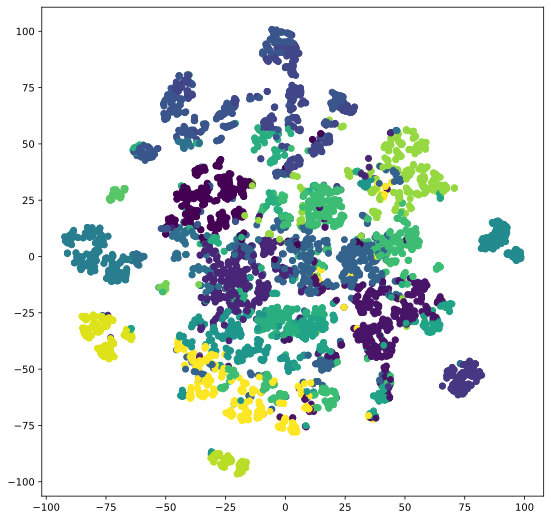

In [105]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

plt.show()

In [106]:
labels_test = kmeans.predict(X_test_scaled)

In [107]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

y_test_pred = lr.predict(X_test_scaled)

print_score(y_test, y_test_pred)

r2: 0.5289  MAE: 44,021


In [108]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

for ind in range(0, 20):
    lr.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = lr.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.5384  MAE: 25,287
r2: 0.4429  MAE: 29,569
r2: 0.1708  MAE: 77,663
r2: 0.1179  MAE: 52,458
r2: 0.4727  MAE: 22,132
r2: 0.5540  MAE: 16,901
r2: 0.3270  MAE: 48,044
r2: 0.6808  MAE: 46,090
r2: 0.6625  MAE: 20,825
r2: 0.5708  MAE: 34,900
r2: 0.4465  MAE: 49,402
r2: 0.3775  MAE: 59,998
r2: 0.4286  MAE: 58,431
r2: 0.3392  MAE: 21,960
r2: 0.6833  MAE: 23,658
r2: 0.8147  MAE: 50,248
r2: 0.4950  MAE: 24,210
r2: 0.7073  MAE: 24,138
r2: 0.5353  MAE: 28,926
r2: 0.5861  MAE: 24,368
Количество кластеров: 20 summ r2: 0.6488 summ MAE: 34,812


In [109]:
for ind_2 in range(3, 31):
    kmeans = KMeans(n_clusters=ind_2, random_state=42)
    labels_train = kmeans.fit_predict(X_train_scaled)
    labels_test = kmeans.predict(X_test_scaled)

    y_test_all = pd.DataFrame()
    y_test_pred_all = pd.DataFrame()

    for ind in range(0, ind_2):
        lr.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
        y_test_pred = lr.predict(X_test_scaled.loc[labels_test == ind])
        #print_score(y_test[labels_test == ind], y_test_pred)
        y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
        y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
    print("Кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind_2, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

Кластеров: 3 summ r2: 0.5951 summ MAE: 38,766
Кластеров: 4 summ r2: 0.6070 summ MAE: 37,649
Кластеров: 5 summ r2: 0.6063 summ MAE: 37,727
Кластеров: 6 summ r2: -428789363486067083182080.0000 summ MAE: 1,108,329,808,396,721
Кластеров: 7 summ r2: 0.6087 summ MAE: 37,538
Кластеров: 8 summ r2: -661448726746346029056.0000 summ MAE: 43,530,645,237,366
Кластеров: 9 summ r2: 0.6167 summ MAE: 36,895
Кластеров: 10 summ r2: 0.6200 summ MAE: 36,387
Кластеров: 11 summ r2: 0.6307 summ MAE: 35,878
Кластеров: 12 summ r2: 0.6237 summ MAE: 36,513
Кластеров: 13 summ r2: 0.6329 summ MAE: 35,874
Кластеров: 14 summ r2: 0.6346 summ MAE: 35,680
Кластеров: 15 summ r2: 0.6439 summ MAE: 35,126
Кластеров: 16 summ r2: 0.6453 summ MAE: 34,918
Кластеров: 17 summ r2: 0.6404 summ MAE: 34,760
Кластеров: 18 summ r2: 0.6522 summ MAE: 34,806
Кластеров: 19 summ r2: 0.6576 summ MAE: 34,368
Кластеров: 20 summ r2: 0.6488 summ MAE: 34,812
Кластеров: 21 summ r2: 0.6525 summ MAE: 34,459
Кластеров: 22 summ r2: 0.6263 summ MAE: 34

In [110]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X_train_scaled, y_train.values[:, 0])
y_pred = model.predict(X_test_scaled)

print_score(y_test, y_pred)

r2: 0.6236  MAE: 35,212


In [111]:
for ind in range(3, 16):
    model = KNeighborsRegressor(n_neighbors=ind)
    model.fit(X_train_scaled, y_train.values[:, 0])
    y_pred = model.predict(X_test_scaled)
    print_score(y_test, y_pred)

r2: 0.6067  MAE: 35,628
r2: 0.6086  MAE: 35,516
r2: 0.6175  MAE: 35,259
r2: 0.6236  MAE: 35,212
r2: 0.6275  MAE: 35,268
r2: 0.6304  MAE: 35,257
r2: 0.6333  MAE: 35,189
r2: 0.6292  MAE: 35,532
r2: 0.6300  MAE: 35,527
r2: 0.6298  MAE: 35,580
r2: 0.6300  MAE: 35,652
r2: 0.6322  MAE: 35,667
r2: 0.6320  MAE: 35,654


In [112]:
kmeans = KMeans(n_clusters=20, random_state=42)
labels_train = kmeans.fit_predict(X_train_scaled)
labels_test = kmeans.predict(X_test_scaled)

y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()
model = KNeighborsRegressor(n_neighbors=9)
for ind in range(0, 20):
    model.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = model.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.3614  MAE: 30,366
r2: 0.3760  MAE: 31,220
r2: 0.0853  MAE: 82,003
r2: 0.2814  MAE: 46,258
r2: 0.6141  MAE: 17,935
r2: 0.6014  MAE: 17,216
r2: 0.2125  MAE: 51,800
r2: 0.5007  MAE: 53,349
r2: 0.6296  MAE: 21,164
r2: 0.6027  MAE: 35,456
r2: 0.2560  MAE: 54,446
r2: 0.4093  MAE: 65,778
r2: 0.4741  MAE: 53,240
r2: 0.2531  MAE: 23,019
r2: 0.5509  MAE: 26,484
r2: 0.4522  MAE: 53,070
r2: 0.4119  MAE: 25,662
r2: 0.7301  MAE: 23,957
r2: 0.3944  MAE: 34,852
r2: 0.4554  MAE: 28,117
Количество кластеров: 20 summ r2: 0.6180 summ MAE: 36,388


In [113]:
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train_scaled, y_train.values[:, 0])
y_pred = model.predict(X_test_scaled)

print_score(y_test, y_pred)

r2: 0.7211  MAE: 28,892


In [114]:
kmeans = KMeans(n_clusters=20, random_state=42)
labels_train = kmeans.fit_predict(X_train_scaled)
labels_test = kmeans.predict(X_test_scaled)

y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
for ind in range(0, 20):
    model.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = model.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.6794  MAE: 18,776
r2: 0.5472  MAE: 26,507
r2: 0.3140  MAE: 65,702
r2: 0.4398  MAE: 42,584
r2: 0.7727  MAE: 13,056
r2: 0.7092  MAE: 13,408
r2: 0.3492  MAE: 42,161
r2: 0.7041  MAE: 39,953
r2: 0.6780  MAE: 17,661
r2: 0.5791  MAE: 32,311
r2: 0.3486  MAE: 51,502
r2: 0.5095  MAE: 55,752
r2: 0.6409  MAE: 40,184
r2: 0.4722  MAE: 18,756
r2: 0.5570  MAE: 27,761
r2: 0.3373  MAE: 72,733
r2: 0.4942  MAE: 22,867
r2: 0.6928  MAE: 22,954
r2: 0.4472  MAE: 35,290
r2: 0.5850  MAE: 22,739
Количество кластеров: 20 summ r2: 0.7033 summ MAE: 29,984


### TSNE n_components = 3

In [115]:
from sklearn.preprocessing import StandardScaler

X = data.drop(['Id', 'Price'], axis = 1)
#X = data.drop(['Id', 'LifeSquare',  'Ecology_3', 'Price'], axis=1)  #'Rooms',
#X = data[['Rooms', 'Square']]
#X = data[['DistrictId', 'Rooms', 'Square', 'Social_1', 'Helthcare_2', 'LifeSquare', 'KitchenSquare', 'Social_2']]
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [116]:
tsne = TSNE(n_components=3, learning_rate=250, random_state=42)

X_train_tsne = tsne.fit_transform(X_train_scaled)

print('До:\t{}'.format(X_train_scaled.shape))
print('После:\t{}'.format(X_train_tsne.shape))

До:	(6981, 17)
После:	(6981, 3)


In [118]:
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2])

# plt.show()

In [119]:
kmeans = KMeans(n_clusters=20, random_state=42)

labels_train = kmeans.fit_predict(X_train_scaled)

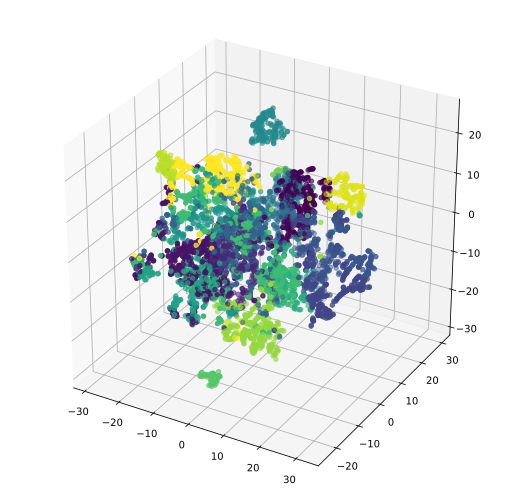

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=labels_train)

plt.show()

In [121]:
labels_test = kmeans.predict(X_test_scaled)

In [122]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

lr = LinearRegression()

for ind in range(0, 20):
    lr.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = lr.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.5384  MAE: 25,287
r2: 0.4429  MAE: 29,569
r2: 0.1708  MAE: 77,663
r2: 0.1179  MAE: 52,458
r2: 0.4727  MAE: 22,132
r2: 0.5540  MAE: 16,901
r2: 0.3270  MAE: 48,044
r2: 0.6808  MAE: 46,090
r2: 0.6625  MAE: 20,825
r2: 0.5708  MAE: 34,900
r2: 0.4465  MAE: 49,402
r2: 0.3775  MAE: 59,998
r2: 0.4286  MAE: 58,431
r2: 0.3392  MAE: 21,960
r2: 0.6833  MAE: 23,658
r2: 0.8147  MAE: 50,248
r2: 0.4950  MAE: 24,210
r2: 0.7073  MAE: 24,138
r2: 0.5353  MAE: 28,926
r2: 0.5861  MAE: 24,368
Количество кластеров: 20 summ r2: 0.6488 summ MAE: 34,812


In [123]:
for ind_2 in range(3, 31):
    kmeans = KMeans(n_clusters=ind_2, random_state=42)
    labels_train = kmeans.fit_predict(X_train_scaled)
    labels_test = kmeans.predict(X_test_scaled)
    
    y_test_all = pd.DataFrame()
    y_test_pred_all = pd.DataFrame()

    for ind in range(0, ind_2):
        lr.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
        y_test_pred = lr.predict(X_test_scaled.loc[labels_test == ind])
        #print_score(y_test[labels_test == ind], y_test_pred)
        y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
        y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
    print("Кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind_2, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

Кластеров: 3 summ r2: 0.5951 summ MAE: 38,766
Кластеров: 4 summ r2: 0.6070 summ MAE: 37,649
Кластеров: 5 summ r2: 0.6063 summ MAE: 37,727
Кластеров: 6 summ r2: -428789363486067083182080.0000 summ MAE: 1,108,329,808,396,721
Кластеров: 7 summ r2: 0.6087 summ MAE: 37,538
Кластеров: 8 summ r2: -661448726746346029056.0000 summ MAE: 43,530,645,237,366
Кластеров: 9 summ r2: 0.6167 summ MAE: 36,895
Кластеров: 10 summ r2: 0.6200 summ MAE: 36,387
Кластеров: 11 summ r2: 0.6307 summ MAE: 35,878
Кластеров: 12 summ r2: 0.6237 summ MAE: 36,513
Кластеров: 13 summ r2: 0.6329 summ MAE: 35,874
Кластеров: 14 summ r2: 0.6346 summ MAE: 35,680
Кластеров: 15 summ r2: 0.6439 summ MAE: 35,126
Кластеров: 16 summ r2: 0.6453 summ MAE: 34,918
Кластеров: 17 summ r2: 0.6404 summ MAE: 34,760
Кластеров: 18 summ r2: 0.6522 summ MAE: 34,806
Кластеров: 19 summ r2: 0.6576 summ MAE: 34,368
Кластеров: 20 summ r2: 0.6488 summ MAE: 34,812
Кластеров: 21 summ r2: 0.6525 summ MAE: 34,459
Кластеров: 22 summ r2: 0.6263 summ MAE: 34

In [124]:
kmeans = KMeans(n_clusters=20, random_state=42)
labels_train = kmeans.fit_predict(X_train_scaled)
labels_test = kmeans.predict(X_test_scaled)

y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()
model = KNeighborsRegressor(n_neighbors=9)
for ind in range(0, 20):
    model.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = model.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.3614  MAE: 30,366
r2: 0.3760  MAE: 31,220
r2: 0.0853  MAE: 82,003
r2: 0.2814  MAE: 46,258
r2: 0.6141  MAE: 17,935
r2: 0.6014  MAE: 17,216
r2: 0.2125  MAE: 51,800
r2: 0.5007  MAE: 53,349
r2: 0.6296  MAE: 21,164
r2: 0.6027  MAE: 35,456
r2: 0.2560  MAE: 54,446
r2: 0.4093  MAE: 65,778
r2: 0.4741  MAE: 53,240
r2: 0.2531  MAE: 23,019
r2: 0.5509  MAE: 26,484
r2: 0.4522  MAE: 53,070
r2: 0.4119  MAE: 25,662
r2: 0.7301  MAE: 23,957
r2: 0.3944  MAE: 34,852
r2: 0.4554  MAE: 28,117
Количество кластеров: 20 summ r2: 0.6180 summ MAE: 36,388


In [125]:
kmeans = KMeans(n_clusters=20, random_state=42)
labels_train = kmeans.fit_predict(X_train_scaled)
labels_test = kmeans.predict(X_test_scaled)

y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
for ind in range(0, 20):
    model.fit(X_train_scaled.loc[labels_train == ind], y_train[labels_train == ind])
    y_test_pred = model.predict(X_test_scaled.loc[labels_test == ind])
    print_score(y_test[labels_test == ind], y_test_pred)
    y_test_all = pd.concat([y_test_all, y_test[labels_test == ind]], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_test_pred)], axis=0, ignore_index=True)
print("Количество кластеров: {} summ r2: {:.4f} summ MAE: {:,.0f}".format(ind + 1, r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

r2: 0.6794  MAE: 18,776
r2: 0.5472  MAE: 26,507
r2: 0.3140  MAE: 65,702
r2: 0.4398  MAE: 42,584
r2: 0.7727  MAE: 13,056
r2: 0.7092  MAE: 13,408
r2: 0.3492  MAE: 42,161
r2: 0.7041  MAE: 39,953
r2: 0.6780  MAE: 17,661
r2: 0.5791  MAE: 32,311
r2: 0.3486  MAE: 51,502
r2: 0.5095  MAE: 55,752
r2: 0.6409  MAE: 40,184
r2: 0.4722  MAE: 18,756
r2: 0.5570  MAE: 27,761
r2: 0.3373  MAE: 72,733
r2: 0.4942  MAE: 22,867
r2: 0.6928  MAE: 22,954
r2: 0.4472  MAE: 35,290
r2: 0.5850  MAE: 22,739
Количество кластеров: 20 summ r2: 0.7033 summ MAE: 29,984


### Пробую разделить на два массива

In [126]:
data = pd.read_csv("tr_01_cor.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)

In [127]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_1.fit(X_train_1, y_train_1.values[:, 0])
y_pred_1 = model_1.predict(X_test_1)

print_score(y_test_1, y_pred_1)

r2: 0.6745  MAE: 32,898


In [128]:
data = pd.read_csv("tr_02_cor.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [129]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_train_2, y_train_2.values[:, 0])
y_pred_2 = model_2.predict(X_test_2)

print_score(y_test_2, y_pred_2)

r2: 0.7799  MAE: 21,722


In [130]:
y_pred_3 = model_2.predict(X_test_1)

print_score(y_test_1, y_pred_3)

r2: 0.4600  MAE: 44,137


In [131]:
y_pred_4 = model_1.predict(X_test_2)

print_score(y_test_2, y_pred_4)

r2: 0.3326  MAE: 49,365


In [132]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

y_test_all = pd.concat([y_test_1, y_test_2], axis=0, ignore_index=True)
y_test_pred_all = pd.concat([pd.DataFrame(y_pred_1, columns=['Price']), pd.DataFrame(y_pred_2, columns=['Price'])], axis=0, ignore_index=True)
print("summ r2: {:.4f} summ MAE: {:,.0f}".format(r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

summ r2: 0.7313 summ MAE: 28,191


### Пробую разделить на четыре массива

In [135]:
data = pd.read_csv("d4_1_over_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [136]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_1.fit(X_train_1, y_train_1.values[:, 0])
y_pred_1 = model_1.predict(X_test_1)

print_score(y_test_1, y_pred_1)

r2: 0.6566  MAE: 40,725


In [137]:
lr = LinearRegression()
lr.fit(X_train_1, y_train_1)
y_pred_lr = lr.predict(X_test_1)

print_score(y_test_1, y_pred_lr)

r2: 0.5476  MAE: 49,698


In [138]:
data = pd.read_csv("d4_2_6276_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [139]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_train_2, y_train_2.values[:, 0])
y_pred_2 = model_2.predict(X_test_2)

print_score(y_test_2, y_pred_2)

r2: 0.6554  MAE: 24,961


In [140]:
data = pd.read_csv("d4_3_77_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [141]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)

model_3 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_3.fit(X_train_3, y_train_3.values[:, 0])
y_pred_3 = model_3.predict(X_test_3)

print_score(y_test_3, y_pred_3)

r2: 0.7951  MAE: 17,828


In [142]:
data = pd.read_csv("d4_4_1418_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [143]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_4.fit(X_train_4, y_train_4.values[:, 0])
y_pred_4 = model_4.predict(X_test_4)

print_score(y_test_4, y_pred_4)

r2: 0.7817  MAE: 26,995


In [144]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

y_test_all = pd.concat([y_test_1, y_test_2, y_test_3, y_test_4], axis=0, ignore_index=True)
y_test_pred_all = pd.concat([pd.DataFrame(y_pred_1, columns=['Price']), pd.DataFrame(y_pred_2, columns=['Price']), pd.DataFrame(y_pred_3, columns=['Price']), pd.DataFrame(y_pred_4, columns=['Price'])], axis=0, ignore_index=True)
print("summ r2: {:.4f} summ MAE: {:,.0f}".format(r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

summ r2: 0.7343 summ MAE: 29,077


### Пробую разделить на три массива

In [145]:
data = pd.read_csv("d3_1_over_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [146]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_1.fit(X_train_1, y_train_1.values[:, 0])
y_pred_1 = model_1.predict(X_test_1)

print_score(y_test_1, y_pred_1)

r2: 0.6563  MAE: 32,958


In [147]:
data = pd.read_csv("d3_2_77_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [148]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_train_2, y_train_2.values[:, 0])
y_pred_2 = model_2.predict(X_test_2)

print_score(y_test_2, y_pred_2)

r2: 0.7951  MAE: 17,828


In [149]:
data = pd.read_csv("d3_3_1418_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [150]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)

model_3 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_3.fit(X_train_3, y_train_3.values[:, 0])
y_pred_3 = model_3.predict(X_test_3)

print_score(y_test_3, y_pred_3)

r2: 0.7817  MAE: 26,995


In [151]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

y_test_all = pd.concat([y_test_1, y_test_2, y_test_3], axis=0, ignore_index=True)
y_test_pred_all = pd.concat([pd.DataFrame(y_pred_1, columns=['Price']), pd.DataFrame(y_pred_2, columns=['Price']), pd.DataFrame(y_pred_3, columns=['Price'])], axis=0, ignore_index=True)
print("summ r2: {:.4f} summ MAE: {:,.0f}".format(r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

summ r2: 0.7173 summ MAE: 28,172


## Датасет разделён на три массива. Модель для первой группы обучается с полным массивом

In [152]:
data = pd.read_csv("train_cor.csv", sep=",")

In [153]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)

r2: 0.7293  MAE: 27,446


In [154]:
data = pd.read_csv("d3_1_over_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [155]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_1 = model.predict(X_test_1)

print_score(y_test_1, y_pred_1)

r2: 0.8270  MAE: 24,440


#### не используем эту оценку

In [156]:
data = pd.read_csv("d3_2_77_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [157]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_train_2, y_train_2.values[:, 0])
y_pred_2 = model_2.predict(X_test_2)

print_score(y_test_2, y_pred_2)

r2: 0.7951  MAE: 17,828


In [158]:
for ind in range(1, 10):
    model_v = RandomForestRegressor(max_depth=12, n_estimators = ind * 25, random_state=42)
    model_v.fit(X_train_2, y_train_2.values[:, 0])
    y_pred_v = model_v.predict(X_test_2)
    print("n_estimators: {} r2: {:.4f} summ MAE: {:,.0f}".format(ind * 25, r2_score(y_test_2, y_pred_v), mean_absolute_error(y_test_2, y_pred_v)))

n_estimators: 25 r2: 0.7856 summ MAE: 17,958
n_estimators: 50 r2: 0.7921 summ MAE: 17,832
n_estimators: 75 r2: 0.7951 summ MAE: 17,828
n_estimators: 100 r2: 0.7931 summ MAE: 17,926
n_estimators: 125 r2: 0.7935 summ MAE: 17,928
n_estimators: 150 r2: 0.7937 summ MAE: 17,896
n_estimators: 175 r2: 0.7942 summ MAE: 17,885
n_estimators: 200 r2: 0.7965 summ MAE: 17,815
n_estimators: 225 r2: 0.7959 summ MAE: 17,802


In [159]:
data = pd.read_csv("d3_3_1418_c.csv", sep=",")
data = data.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data["Ecology_2"] = data["Ecology_2"].map(map_AB)
data["Ecology_3"] = data["Ecology_3"].map(map_AB)
data["Shops_2"] = data["Shops_2"].map(map_AB)
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [160]:
X = data.drop(['Price', 'Id'], axis = 1)#, 'Rooms', 'LifeSquare'
y = data[['Price']]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)

model_3 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_3.fit(X_train_3, y_train_3.values[:, 0])
y_pred_3 = model_3.predict(X_test_3)

print_score(y_test_3, y_pred_3)

r2: 0.7817  MAE: 26,995


In [161]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

y_test_all = pd.concat([y_test, y_test_2, y_test_3], axis=0, ignore_index=True)
y_test_pred_all = pd.concat([pd.DataFrame(y_pred, columns=['Price']), pd.DataFrame(y_pred_2, columns=['Price']), pd.DataFrame(y_pred_3, columns=['Price'])], axis=0, ignore_index=True)
print("summ r2: {:.4f} summ MAE: {:,.0f}".format(r2_score(y_test_all, y_test_pred_all), mean_absolute_error(y_test_all, y_test_pred_all)))

summ r2: 0.7493 summ MAE: 25,573


### Обучаем модель валидированным набором и тестируем на полных данных

In [162]:
data = pd.read_csv("train_cor_val_c.csv", sep=",")

X = data.drop(['Id', 'LifeSquare','Price'], axis = 1)
y = data[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X_train, y_train.values[:, 0])
y_pred = model.predict(X_test)

print_score(y_test, y_pred)

r2: 0.8194  MAE: 22,206


In [163]:
data = pd.read_csv("train_cor.csv", sep=",")

X_f = data.drop(['Id', 'LifeSquare', 'Price'], axis = 1)
y_f = data[['Price']]

y_pred_f = model.predict(X_f)

print_score(y_f, y_pred_f)

r2: 0.7193  MAE: 26,488


## Формирование выходных данных

#### Первая часть данных

In [171]:
data = pd.read_csv("train_cor_val_c.csv", sep=",")
data_test = pd.read_csv("t_1_o_c.csv", sep=",")

In [172]:
X = data.drop(['Id', 'LifeSquare', 'Price'], axis=1)
y = data[['Price']]

res = data_test[['Id']].copy()
data_test = data_test.drop(['Id', 'LifeSquare'], axis=1)

In [173]:
model = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model.fit(X, y.values[:, 0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [174]:
y_pred = model.predict(data_test)
y_pred

array([464657.2112303 , 110749.96212236, 270630.08358559, ...,
       176820.79725843, 277128.67307665, 171159.81299607])

In [175]:
res = pd.concat([res, pd.DataFrame(y_pred, columns=['Price'])], axis=1)

In [176]:
res.to_csv("R_1.csv", sep=",", index=False)

#### Вторая часть данных

In [177]:
data_2 = pd.read_csv("d3_2_77_c.csv", sep=",")
data_test_2 = pd.read_csv("t_2_77_c.csv", sep=",")

In [178]:
data_2 = data_2.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data_2["Ecology_2"] = data_2["Ecology_2"].map(map_AB)
data_2["Ecology_3"] = data_2["Ecology_3"].map(map_AB)
data_2["Shops_2"] = data_2["Shops_2"].map(map_AB)
data_2['LifeSquare'] = data_2['LifeSquare'].fillna(data_2['LifeSquare'].mean())

X_2 = data_2.drop(['Id', 'LifeSquare', 'Price'], axis=1)
y_2 = data_2[['Price']]

res_2 = data_test_2[['Id']].copy()
data_test_2 = data_test_2.drop(['Id', 'LifeSquare'], axis=1)

In [179]:
model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_2, y_2.values[:, 0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [180]:
y_pred_2 = model_2.predict(data_test_2)
y_pred_2

array([236125.5176151 , 233780.025577  , 167766.2781462 , ...,
       361122.31133864, 197744.17736858, 173873.51604208])

In [181]:
res_2 = pd.concat([res_2, pd.DataFrame(y_pred_2, columns=['Price'])], axis=1)

In [182]:
res_2.to_csv("R_2.csv", sep=",", index=False)

#### Третья часть данных

In [183]:
data_3 = pd.read_csv("d3_3_1418_c.csv", sep=",")
data_test_3 = pd.read_csv("t_3_1418_c.csv", sep=",")

In [184]:
data_3 = data_3.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data_3["Ecology_2"] = data_3["Ecology_2"].map(map_AB)
data_3["Ecology_3"] = data_3["Ecology_3"].map(map_AB)
data_3["Shops_2"] = data_3["Shops_2"].map(map_AB)
data_3['LifeSquare'] = data_3['LifeSquare'].fillna(data_3['LifeSquare'].mean())

X_3 = data_3.drop(['Id', 'LifeSquare', 'Price'], axis=1)
y_3 = data_3[['Price']]

res_3 = data_test_3[['Id']].copy()
data_test_3 = data_test_3.drop(['Id', 'LifeSquare'], axis=1)

In [185]:
model_3 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_3.fit(X_3, y_3.values[:, 0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [189]:
y_pred_3 = model_3.predict(data_test_3)
y_pred_3[:15]

array([205672.14497816, 210064.88535511, 126106.30230206, 216340.85073431,
       162819.10090793,  94571.54420052, 455578.72927916, 177092.94000689,
       390290.10539451, 129270.54513952, 139355.82147643, 132088.36999262,
       189463.53449058, 377233.3227896 , 153243.14902597])

In [187]:
res_3 = pd.concat([res_3, pd.DataFrame(y_pred_3, columns=['Price'])], axis=1)

In [188]:
res_3.to_csv("R_3.csv", sep=",", index=False)

## Результат на private leaderboard: 0.681680

# Рецензия

-У RandomForestRegressor есть атрибут feature_importance, можно было не создавать функцию feature_test. Мне она,честно говоря, совсем непонятна.

-До применения RandomForestRegressor вы не преобразовали districtId - пустили как есть. Это категориальная переменная. Так делать некорректно.  Блоки с 337 по 345

-В подборе гиперпараметров вы начинате с max_depth=9. Это достаточно большая глубина, чтобы с нее начинать. Она и могла легко привести к переобучению. Блок 259

-У вас блоки выполняются не по порядку, отсюда могли возникнуть ошибки(это неточно)

-Не увидел места. где вы формируете итоговый набор предсказаний, отсюда и не могу сказать более подробно.

# Попробую вариант с разделением на два массива

#### Первая часть данных

In [190]:
data_1 = pd.read_csv("tr_01_cor.csv", sep=",")
data_1 = data_1.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data_1["Ecology_2"] = data_1["Ecology_2"].map(map_AB)
data_1["Ecology_3"] = data_1["Ecology_3"].map(map_AB)
data_1["Shops_2"] = data_1["Shops_2"].map(map_AB)

data_test_1 = pd.read_csv("t_1_o_c.csv", sep=",")

In [191]:
X_1 = data_1.drop(['Price', 'Id'], axis = 1)
y_1 = data_1[['Price']]

res_1 = data_test_1[['Id']].copy()
data_test_1 = data_test_1.drop(['Id'], axis=1)

model_1 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_1.fit(X_1, y_1.values[:, 0])

y_pred_1 = model_1.predict(data_test_1)
y_pred_1

array([400585.45276159, 275201.07794738, 267676.52287633, ...,
       173315.89251081, 204850.51897035, 160333.30506871])

In [192]:
res_1 = pd.concat([res_1, pd.DataFrame(y_pred_1, columns=['Price'])], axis=1)

In [193]:
res_1.to_csv("R_1.csv", sep=",", index=False)

#### Вторая часть данных

In [196]:
data_2 = pd.read_csv("tr_02_cor.csv", sep=",")
data_2 = data_2.drop('Healthcare_1', axis=1)
map_AB = {
    'A': 0,
    'B': 1
}
data_2["Ecology_2"] = data_2["Ecology_2"].map(map_AB)
data_2["Ecology_3"] = data_2["Ecology_3"].map(map_AB)
data_2["Shops_2"] = data_2["Shops_2"].map(map_AB)
data_2['LifeSquare'] = data_2['LifeSquare'].fillna(data_2['LifeSquare'].mean())

data_test_2 = pd.read_csv("t_2_77_1418_c.csv", sep=",")

In [197]:
X_2 = data_2.drop(['Price', 'Id'], axis = 1)
y_2 = data_2[['Price']]

res_2 = data_test_2[['Id']].copy()
data_test_2 = data_test_2.drop(['Id'], axis=1)

model_2 = RandomForestRegressor(max_depth=12, n_estimators=75, random_state=42)
model_2.fit(X_2, y_2.values[:, 0])

y_pred_2 = model_2.predict(data_test_2)
y_pred_2

array([227122.83944701, 207602.70703025, 170660.29214685, ...,
       200407.1640627 , 243347.65466973, 465943.32131255])

In [198]:
res_2 = pd.concat([res_2, pd.DataFrame(y_pred_2, columns=['Price'])], axis=1)

In [199]:
res_2.to_csv("R_2.csv", sep=",", index=False)

## Результат на private leaderboard: 0.727396